In [13]:
import os
import sys
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import os
import random
import numpy as np
import torch
from tqdm import tqdm
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerSegmentation
from dfc_dataset import DFCDataset
import torch.nn.functional as F


data_config = {
    'train_dir': '../data/data_disini', # path to the training directory,  
    'val_dir': '../data/data_disini', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 8, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

train_dataset = DFCDataset(
    data_config['train_dir'],
    mode=data_config['train_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['train_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_train'],
    seed=data_config['seed'],
)

val_dataset = DFCDataset(
    data_config['val_dir'],
    mode=data_config['val_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['val_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_validation'],
    seed=data_config['seed'],
)

DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': True, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 5, 
    'target': 'dfc_label'
}

/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# path to the checkpoint
checkpoint = torch.load("../checkpoints/swin_t.pth",map_location=torch.device('cpu')) 
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}

from utils import dotdictify
from Transformer_SSL.models import build_model
import json

device = torch.device('cpu')
input_channels = train_config['s1_input_channels'] + train_config['s2_input_channels']

with open("../configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)

# create a new model's instance
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device)

model = model.to(device)

# load checkpoints weights
model.load_state_dict(torch.load("../checkpoints/frozen/Segmentation epoch 195.pth", map_location=torch.device("cpu")))
# model.load_state_dict(torch.load("../checkpoints/finetuning/Segmentation epoch 200.pth", map_location=torch.device("cpu")))

/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

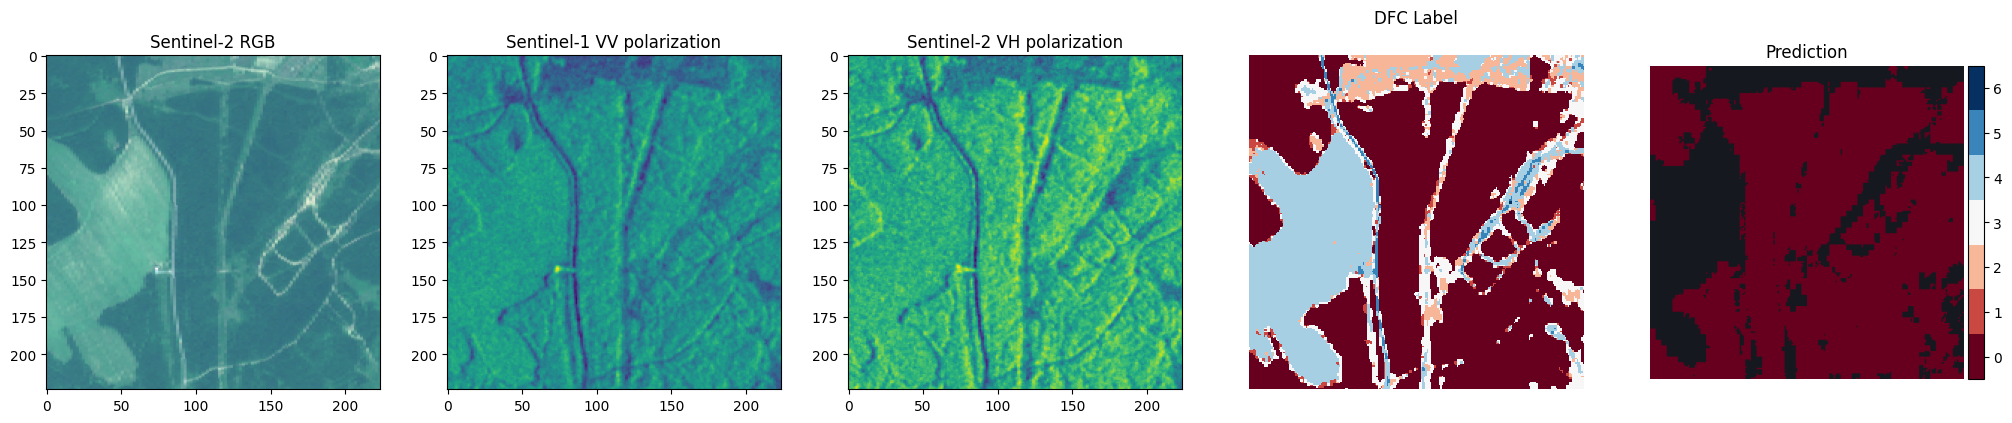

Forest


In [15]:
# 11 16 17 19 20 26 29 50 65 82 95 128 144 148 154
# 95, 128, 144, 154
img_index = 128

img = {"s1": torch.unsqueeze(train_dataset[img_index]['s1'], 0), "s2": torch.unsqueeze(train_dataset[img_index]['s2'], 0)}
model.eval()
output = model(img)
probas = F.softmax(output, dim=1)
pred = torch.argmax(probas, axis=1)

train_dataset.visualize_observation_prediction(idx=img_index, pred=pred, forest_only=True)
print(DFC_map_clean[train_dataset[img_index]['dfc_label']])

In [ ]:
DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

Random crop

In [77]:
import numpy as np
import random
from enum import Enum
import rasterio
from rasterio.windows import Window

import albumentations as A
from src.utils import AlbumentationsToTorchTransform
from albumentations.pytorch import ToTensorV2


class S1Bands(Enum):
    VV = 1
    VH = 2
    ALL = [VV, VH]
    NONE = None

class Sensor(Enum):
    s1 = "s1"
    s2 = "s2"
    lc = "lc"
    dfc = "dfc"

class S2Bands(Enum):
    B01 = aerosol = 1
    B02 = blue = 2
    B03 = green = 3
    B04 = red = 4
    B05 = re1 = 5
    B06 = re2 = 6
    B07 = re3 = 7
    B08 = nir1 = 8
    B08A = nir2 = 9
    B09 = vapor = 10
    B10 = cirrus = 11
    B11 = swir1 = 12
    B12 = swir2 = 13
    ALL = [B01, B02, B03, B04, B05, B06, B07, B08, B08A, B09, B10, B11, B12]
    RGB = [B04, B03, B02]
    NONE = None

class LCBands(Enum):
    LC = lc = 0
    DFC = dfc = 1
    ALL = [DFC]
    NONE = None

def get_patch(patch_path, bands, window=None):
    """
        Returns raster data and image bounds for the defined bands of a specific patch
        This method only loads a sinlge patch from a single sensor as defined by the bands specified
    """
    # season = Seasons(season).value
    sensor = None

    if not bands:
        return None, None

    if isinstance(bands, (list, tuple)):
        b = bands[0]
    else:
        b = bands
    
    if isinstance(b, S1Bands):
        sensor = Sensor.s1.value
        bandEnum = S1Bands
    elif isinstance(b, S2Bands):
        sensor = Sensor.s2.value
        bandEnum = S2Bands
    elif isinstance(b, LCBands):
        if LCBands(bands) == LCBands.LC:
            sensor = Sensor.lc.value 
        else:
            sensor = Sensor.dfc.value 

        bands = LCBands(1)
        bandEnum = LCBands
    else:
        raise Exception("Invalid bands specified")

    if isinstance(bands, (list, tuple)):
        bands = [b.value for b in bands]
    else:
        bands = bandEnum(bands).value

    with rasterio.open(patch_path) as patch:
        if window is not None:
            data = patch.read(bands, window=window) 
        else:
            data = patch.read(bands)
        bounds = patch.bounds

    if len(data.shape) == 2:
        data = np.expand_dims(data, axis=0)

    print(window)

    return data, bounds


# random.seed(1)
image_px_size = 224
if image_px_size != 256:
    x_offset, y_offset = np.random.randint(0, 256 - image_px_size, 2)
    window = Window(x_offset, y_offset, image_px_size, image_px_size)
else:
    window = None

s1, bounds1 = get_patch(patch_path="../data/inference/s1_combined.tif", bands=S1Bands.ALL, window=window)
s2, bounds1 = get_patch(patch_path="../data/inference/S2 Composite.tif", bands=S2Bands.ALL, window=window)
s1

Window(col_off=30, row_off=17, width=224, height=224)
Window(col_off=30, row_off=17, width=224, height=224)


array([[[347, 265, 221, ..., 262, 238, 358],
        [288, 304, 199, ..., 332, 189, 379],
        [246, 264, 179, ..., 396, 223, 324],
        ...,
        [550, 514, 386, ..., 363, 454, 535],
        [640, 605, 431, ..., 285, 384, 392],
        [542, 512, 431, ..., 390, 230, 175]],

       [[117,  78,  91, ..., 119, 103,  98],
        [126, 100, 109, ..., 136, 107,  87],
        [110, 117, 103, ..., 143,  93,  74],
        ...,
        [246, 231, 169, ..., 248, 270, 160],
        [232, 248, 240, ..., 245, 251, 120],
        [176, 244, 240, ..., 174, 118, 167]]], dtype=uint16)

In [78]:
clip_sample_values = True
if clip_sample_values:
    s1 = np.clip(s1, a_min=-25, a_max=0)
    s1 = (
        s1 + 25
    )
    s2 = np.clip(s2, a_min=0, a_max=1e4)

base_aug = A.Compose([ToTensorV2()])
base_transform = AlbumentationsToTorchTransform(base_aug)

s1

array([[[25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        ...,
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25]],

       [[25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        ...,
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25]]], dtype=int32)

In [ ]:

s1 = base_transform(np.moveaxis(s1, 0, -1))
s2 = base_transform(np.moveaxis(s2, 0, -1))
s1

In [ ]:
s1_maxs = []
for ch_idx in range(s1.shape[0]):
    s1_maxs.append(
        torch.ones((s1.shape[-2], s1.shape[-1])) * s1[ch_idx].max().item()
        + 1e-5
    )
s1_maxs = torch.stack(s1_maxs)
s2_maxs = []
for b_idx in range(s2.shape[0]):
    s2_maxs.append(
        torch.ones((s2.shape[-2], s2.shape[-1])) * s2[b_idx].max().item() + 1e-5
    )
s2_maxs = torch.stack(s2_maxs)

normalize = True
if normalize:
    s1 = s1 / s1_maxs
    s2 = s2 / s2_maxs

s1

Clip image

In [1]:
import rasterio
from rasterio.windows import Window
import numpy as np

# Function to generate crop windows based on the image dimensions and desired crop size
def get_crop_windows(width, height, crop_size):
    # Calculate the number of complete crops in both dimensions
    n_cols, n_rows = width // crop_size, height // crop_size
    # Iterate over each possible crop position
    for col in range(n_cols + (0 if width % crop_size == 0 else 1)):
        for row in range(n_rows + (0 if height % crop_size == 0 else 1)):
            # Calculate the top-left corner of the crop
            x, y = col * crop_size, row * crop_size
            # Determine the width and height of the crop (may be smaller at the edges)
            w, h = min(crop_size, width - x), min(crop_size, height - y)
            # Yield the window (crop position and size) and its dimensions
            yield Window(x, y, w, h), (w, h)

# Function to crop the image and handle edges with padding
def crop_and_save_image_with_padding(input_path, output_path, crop_size):
    # Open the input image using rasterio
    with rasterio.open(input_path) as src:
        # Iterate over each crop window
        for i, (window, (w, h)) in enumerate(get_crop_windows(src.width, src.height, crop_size)):
            # Check if the crop needs padding (i.e., if it's an edge crop)
            if w != crop_size or h != crop_size:
                # Read the crop from the image with padding to match the out_shape
                crop = src.read(window=window, out_shape=(src.count, crop_size, crop_size))
                # Define padding dimensions to fill the crop to the desired size
                pad_width = ((0, 0), (0, crop_size - h), (0, crop_size - w))
                # Apply padding with zeros (constant_values=0)
                crop = np.pad(crop, pad_width, mode='constant', constant_values=0)
            else:
                # If no padding is needed, just read the crop
                crop = src.read(window=window)
            # Save or process the crop as needed
            # Example: Save the crop to a new file
            # rasterio.open(f'{output_path}_{i}.tif', 'w', **src.meta).write(crop)

def crop_and_save_image_with_padding(input_path, output_path, crop_size, bands):
    # Open the input image using rasterio
    with rasterio.open(input_path) as src:
        # Iterate over each crop window
        for i, (window, (w, h)) in enumerate(get_crop_windows(src.width, src.height, crop_size)):
            # Read the specific bands from the crop, handle padding if needed
            if w != crop_size or h != crop_size:
                # Read the crop from the image with padding to match the out_shape
                crop = src.read(bands, window=window, out_shape=(len(bands), crop_size, crop_size))
                # Define padding dimensions to fill the crop to the desired size
                pad_width = ((0, 0), (0, crop_size - h), (0, crop_size - w))
                # Apply padding with zeros (constant_values=0)
                crop = np.pad(crop, pad_width, mode='constant', constant_values=0)
            else:
                # Read the specific bands from the crop
                crop = src.read(bands, window=window)
            # Save or process the crop as needed
            rasterio.open(f'{output_path}_{i}.tif', 'w', **src.meta).write(crop)


# Specify the crop size
crop_size = 224
s1_bands = [1, 2]
s2_bands = [i for i in range(1, 14)]

crop_and_save_image_with_padding('../data/inference/s1_combined.tif', '../data/inference/crop/s1', crop_size, s1_bands)
# crop_and_save_image_with_padding('path/to/sentinel-1/image.tif', 'path/to/output/crops', crop_size, s2_bands)

KeyboardInterrupt: 